In [38]:
import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import tensorflow as tf

### functions

In [6]:
def create_database_df(dataset_folder: str) -> 'DataFrame':

    """
    This function takes a bird database folder (unzipped) and generate a dataframe with two columns:
    - image_path
    - species
    """

    data_lst = []

    species_folders = os.listdir(dataset_folder)

    for folder in species_folders: 
        for image_file in Path(os.path.join(dataset_folder,folder)).glob("*.jpg"):
            row = {
                'img_path':image_file,
                'species':os.path.basename(image_file).rsplit('_', 1)[0]
            }
            data_lst.append(row)

    return pd.DataFrame(data_lst)

### load data

In [7]:
dataset_path = "../french_bird_db/french_bird_db_50_100"
nb_classes = 50
nb_image_per_class = 100


image_df = create_database_df(dataset_path)
image_df.head()

,img_path,species
0,../french_bird_db/french_bird_db_50_100/phyllo...,phylloscopus_fuscatus
1,../french_bird_db/french_bird_db_50_100/phyllo...,phylloscopus_fuscatus
2,../french_bird_db/french_bird_db_50_100/phyllo...,phylloscopus_fuscatus
3,../french_bird_db/french_bird_db_50_100/phyllo...,phylloscopus_fuscatus
4,../french_bird_db/french_bird_db_50_100/phyllo...,phylloscopus_fuscatus


### clean data

In [8]:
def get_image_size(img_path: str) -> (int, ...):
    '''
    returns a tuple with iamge np_array_shape
    '''
    np_image = plt.imread(img_path)
    return(np_image.shape)


def get_good_images(image_path_df: 'DataFrame', expected_size: (int, ...) = (300,300,3)) -> 'DataFrame':
    '''
    return a dataframe with all image path to delete
    '''
    image_path_df['img_size'] = image_path_df['img_path'].apply(get_image_size)
    return image_path_df.loc[image_path_df['img_size'] == expected_size]

In [9]:
print(image_df.shape)
image_df = get_good_images(image_df)
print(image_df.shape)

(4996, 2)
(4996, 3)


In [33]:
# one hot encode categories
# convert categoreis to number
unique_species = image_df['species'].unique()
nb_unique_species = len(unique_species)
categories_dict = dict(zip(unique_species, list(range(nb_unique_species))))
category2bird_name_dict = {v:k for k, v in categories_dict.items()}
image_df['species'] = image_df['species'].apply(lambda x: categories_dict[x] if x in categories_dict else x)

In [51]:
category2bird_name_dict = {v:k for k, v in categories_dict.items()}

# train test split

In [43]:
image_df_train, image_df_test = train_test_split(image_df, random_state=0, shuffle=True)
image_df_train.shape, image_df_test.shape

((3747, 3), (1249, 3))

# model building (RESNET 34)

In [46]:
import torchvision
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision import models
from torch.utils.data import Dataset, DataLoader
from PIL import Image

In [47]:
# Load dataset
class LargeDataset(Dataset):
    def __init__(self, img_path_df: 'DataFrame', transform: 'function'=None):
        """
        Args:
            img_path_df (DataFrame): Dataframe with two columns: one with path to an image and onther with the corresponding class.
            transform (callable, optional): Optional transform to be applied on a sample when loaded.
        """
        self.img_data = img_path_df
        self.transform = transform

    def __len__(self):
        return len(self.img_data)

    def __getitem__(self, idx):
        img_path = self.img_data.iloc[idx, 0]
        image = Image.open(img_path).convert("RGB")
        label = self.img_data.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        return image, label



In [76]:
# load model 
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
num_classes = nb_classes
model.fc = nn.Linear(model.fc.in_features, num_classes)

# expected normalisation step for the model
normalize_step = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                      std=[0.229, 0.224, 0.225])

transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224 pixels
    transforms.ToTensor(),
    normalize_step,  # Normalize based on ImageNet dataset statistics
])

# Load the training and testing datasets
dataset_train = LargeDataset(image_df_train, transform=transform)
dataset_test = LargeDataset(image_df_test, transform=transform)

trainloader = DataLoader(dataset_train, batch_size=32, shuffle=True, num_workers=2)
testloader = DataLoader(dataset_test, batch_size=32, shuffle=False, num_workers=2)

# loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)



In [50]:
# Move the model to the GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

# Training loop
for epoch in range(10):  # Number of epochs
    running_loss = 0.0
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()  # Zero the parameter gradients

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()  # backward propagation
        optimizer.step()

        running_loss += loss.item()

    print(f'Epoch [{epoch + 1}/10], Loss: {running_loss/len(trainloader)}')

print('Finished Training')

Epoch [1/10], Loss: 3.2868856434094704
Epoch [2/10], Loss: 1.8720177048343722
Epoch [3/10], Loss: 1.2145699469719904
Epoch [4/10], Loss: 0.8660603251497624
Epoch [5/10], Loss: 0.63979855710167
Epoch [6/10], Loss: 0.48350999163369
Epoch [7/10], Loss: 0.3618860460691533
Epoch [8/10], Loss: 0.2768861696881763
Epoch [9/10], Loss: 0.21526442392397735
Epoch [10/10], Loss: 0.16807067005942433
Finished Training


In [ ]:
#Evaluation mode
model.eval()
correct = 0
total = 0

output_lst = []
predicted_lst = []
test_input_lst = []
test_labels_lst = []
with torch.no_grad():
    for inputs, labels in testloader:
        
        test_input_lst.append(inputs)
        test_labels_lst.append(labels)

        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        output_lst.append(outputs)
        _, predicted = torch.max(outputs.data, 1)
        predicted_lst.append(predicted)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the test images: {100 * correct / total}%')


Accuracy of the network on the test images: 2.9623698959167335%


(3, 224, 224)

In [98]:
# Display some images with image to predict and predicted bird

def get_random_bird_image_from_species(species_number: int, image_df: 'DataFrame') -> str:
    """
    return path of a random bird iamge from the class of the specie from the dataset
    """
    return image_df.loc[image_df['species'] == species_number, ['img_path']].sample(n=1).iloc[0,0]


def get_species_name_from_number(species_number: int, number2name_dict: dict) -> str:
    return number2name_dict[species_number]

In [59]:
outputs.shape

torch.Size([32, 50])

In [79]:
torch.max(output_lst[0].data, 1)

torch.return_types.max(
values=tensor([2.4414, 1.7382, 2.0549, 2.4388, 1.5380, 2.0678, 2.8211, 1.7045, 2.2209,
        1.9136, 1.6721, 1.5098, 1.8307, 1.8942, 1.6265, 1.7330, 1.4538, 1.6611,
        1.7285, 1.2939, 1.7438, 1.8265, 1.9185, 1.9648, 1.7275, 1.8484, 1.5936,
        2.4955, 1.7353, 1.8652, 1.7033, 1.7040]),
indices=tensor([19, 19, 27, 27, 19, 19, 27, 23, 19, 19, 19, 19, 19, 19, 19, 19, 44, 23,
        44, 19, 27, 19, 27, 19, 19, 27, 44, 19, 19, 23, 19, 23]))

In [96]:
test_input_lst[0]

tensor([[[[ 2.2318,  2.1975,  2.0263,  ...,  1.2214,  1.1700,  1.2385],
          [ 2.1633,  2.2147,  2.1462,  ...,  1.7180,  1.5639,  1.4783],
          [ 1.9407,  2.2318,  2.1975,  ...,  0.7762,  1.1015,  1.8379],
          ...,
          [ 0.2453,  0.2282,  0.1597,  ..., -0.0287, -0.0287, -0.0116],
          [ 0.0912, -0.0287,  0.0056,  ..., -0.0287, -0.0287, -0.0287],
          [ 0.0398,  0.0227,  1.1015,  ...,  0.0056, -0.0116, -0.0287]],

         [[ 2.3585,  2.3060,  2.1660,  ...,  1.2556,  1.0805,  1.1681],
          [ 2.3936,  2.3761,  2.1485,  ...,  1.6583,  1.5007,  1.4132],
          [ 2.3936,  2.3936,  2.2185,  ...,  1.7983,  2.0259,  1.9734],
          ...,
          [ 0.2927,  0.2752,  0.2052,  ...,  0.0476,  0.0476,  0.0651],
          [ 0.1702,  0.0301,  0.0476,  ...,  0.0476,  0.0476,  0.0476],
          [ 0.1176,  0.0651,  1.1506,  ...,  0.0826,  0.0651,  0.0476]],

         [[ 2.5703,  2.0125,  1.4200,  ...,  0.5136,  0.3916,  0.2696],
          [ 2.6051,  2.3786,  

In [111]:
test_input_lst[0][0]

tensor([[[ 2.2318,  2.1975,  2.0263,  ...,  1.2214,  1.1700,  1.2385],
         [ 2.1633,  2.2147,  2.1462,  ...,  1.7180,  1.5639,  1.4783],
         [ 1.9407,  2.2318,  2.1975,  ...,  0.7762,  1.1015,  1.8379],
         ...,
         [ 0.2453,  0.2282,  0.1597,  ..., -0.0287, -0.0287, -0.0116],
         [ 0.0912, -0.0287,  0.0056,  ..., -0.0287, -0.0287, -0.0287],
         [ 0.0398,  0.0227,  1.1015,  ...,  0.0056, -0.0116, -0.0287]],

        [[ 2.3585,  2.3060,  2.1660,  ...,  1.2556,  1.0805,  1.1681],
         [ 2.3936,  2.3761,  2.1485,  ...,  1.6583,  1.5007,  1.4132],
         [ 2.3936,  2.3936,  2.2185,  ...,  1.7983,  2.0259,  1.9734],
         ...,
         [ 0.2927,  0.2752,  0.2052,  ...,  0.0476,  0.0476,  0.0651],
         [ 0.1702,  0.0301,  0.0476,  ...,  0.0476,  0.0476,  0.0476],
         [ 0.1176,  0.0651,  1.1506,  ...,  0.0826,  0.0651,  0.0476]],

        [[ 2.5703,  2.0125,  1.4200,  ...,  0.5136,  0.3916,  0.2696],
         [ 2.6051,  2.3786,  1.4548,  ...,  0

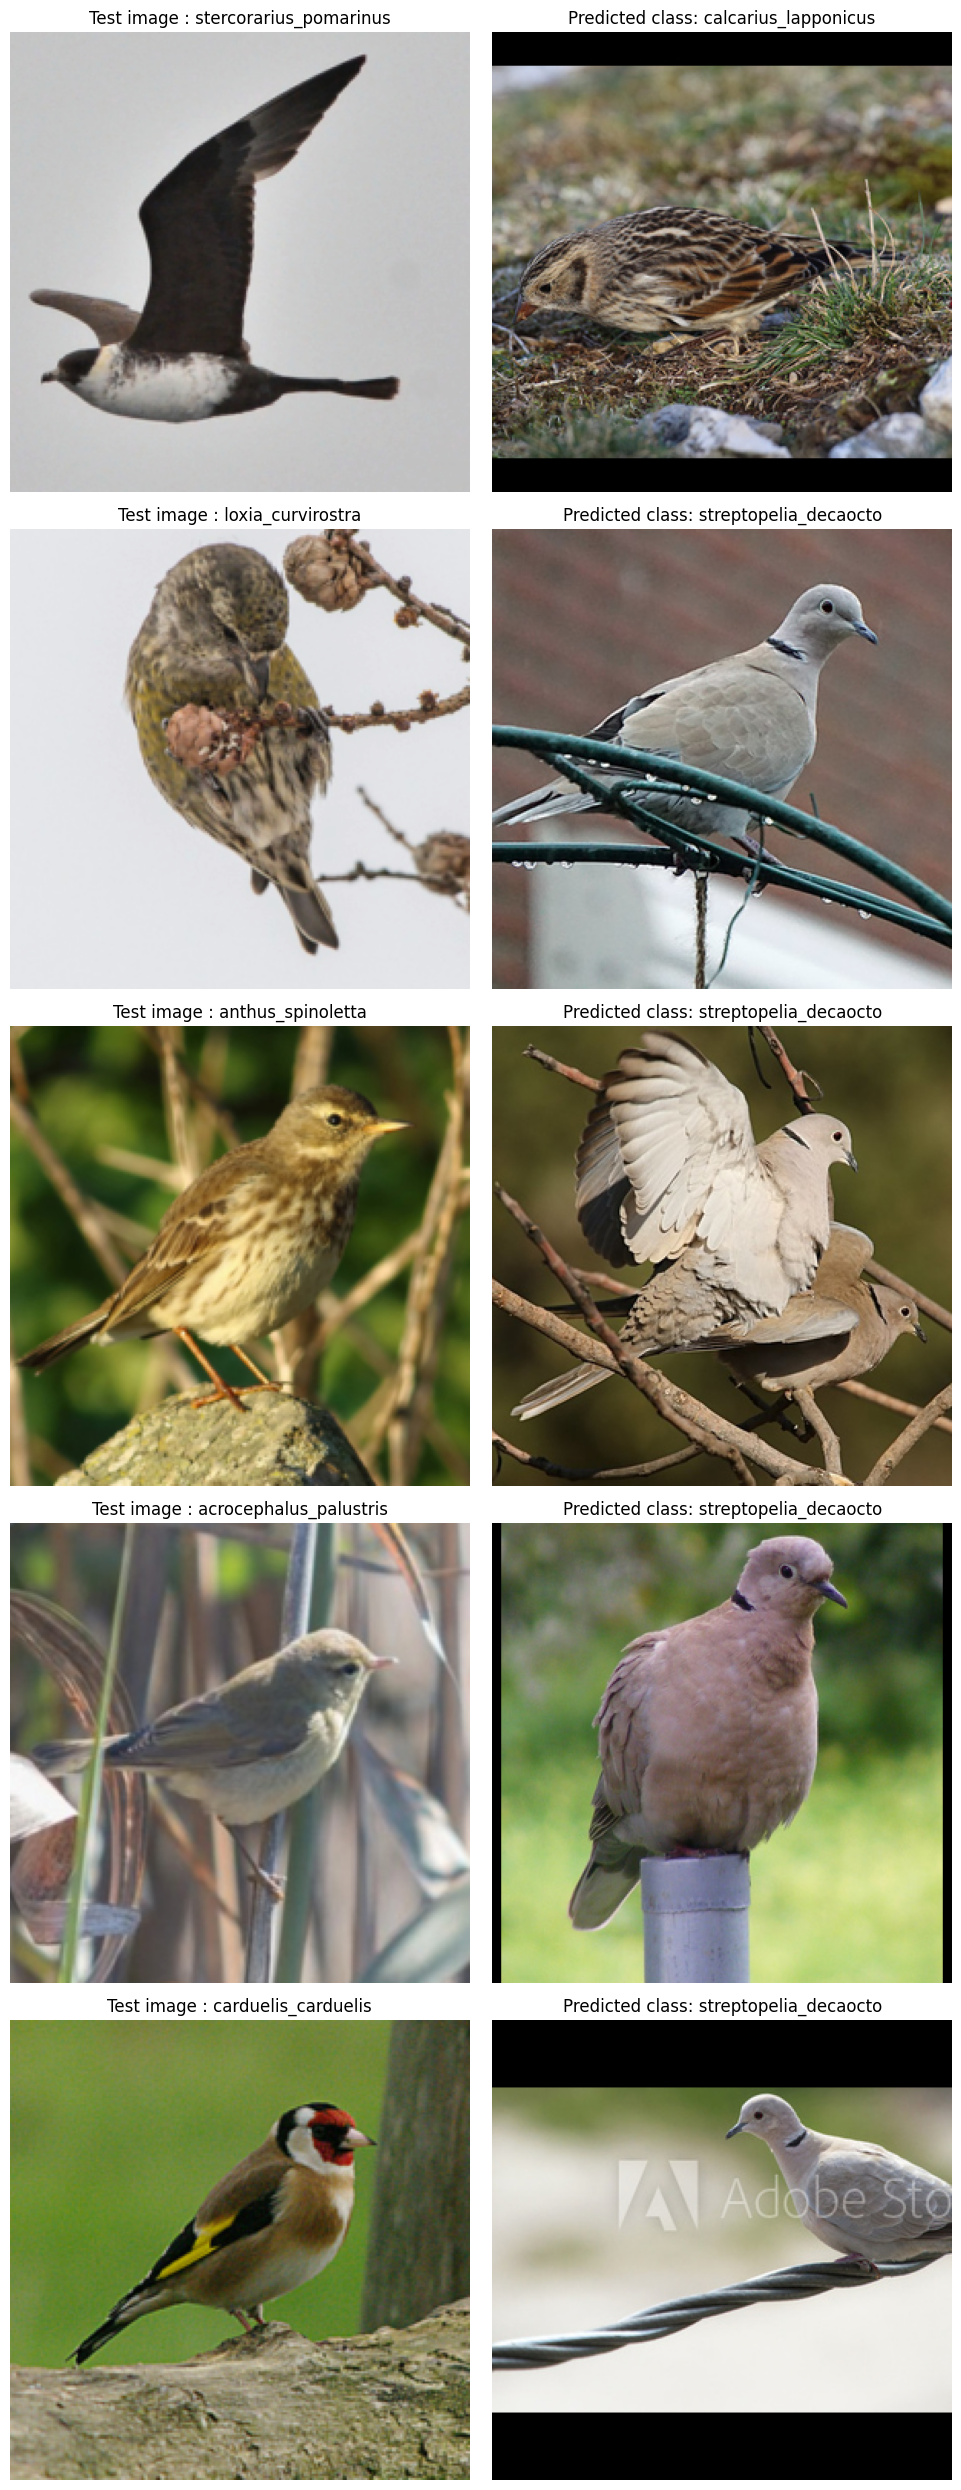

In [115]:
import matplotlib.pyplot as plt

# load prediction from output



batch_index = 1
nb_images_to_plot = 5


fig, axes = plt.subplots(nb_images_to_plot, 2, figsize=(10, 5*nb_images_to_plot))


for img_index in range(nb_images_to_plot):

    test_label = int(test_labels_lst[batch_index][img_index])
    test_species_name = get_species_name_from_number(test_label, category2bird_name_dict)

    # try to recover as much data as possible by denormalizating image
    test_img = test_input_lst[batch_index][img_index]
    # test_img = np.moveaxis(np.array(test_input_lst[batch_index])[img_index,:,:,:], [0,1,2], [2,0,1])

    denormalize_step = transforms.Normalize(
        mean=[-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225],
        std=[1 / 0.229, 1 / 0.224, 1 / 0.225]
    )

    denormalized_img = denormalize_step(test_img)
    test_img = transforms.ToPILImage()(denormalized_img)

    species_number_pred = int(predicted_lst[batch_index][img_index])
    species_name_pred = get_species_name_from_number(species_number_pred, category2bird_name_dict)
    pred_img_path = get_random_bird_image_from_species(species_number_pred, image_df)
    pred_img = plt.imread(pred_img_path)


    # plot test image
    axes[img_index, 0].imshow(test_img)
    axes[img_index, 0].set_title(f'Test image : {test_species_name}')
    axes[img_index, 0].axis('off')

    # plot sample image of predicted class 
    axes[img_index, 1].imshow(pred_img)
    axes[img_index, 1].set_title(f"Predicted class: {species_name_pred}")
    axes[img_index, 1].axis('off')

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()


